# Projekt Autoenkoder
Indeks: 145317

Wymagania:
- stworzenie sieci neuronowej typu autoencoder
- dane wejściowe to obrazy czarno-białe (1 kanał)
- dane wyjściowe to obrazy kolorowe (3 kanały)
- badanie różnych rozmiarów sieci neuronowej
- badanie wpływu poszczególnych elementów regularyzacji na wynik:
  - wpływ parametru momentum oraz rozmiaru batcha przy wykorzystaniu batch normalization
  - wpływ dropout rate
  - wpływ weight decay

Zrealizowane przy wykorzystaniu bibliotek:
- Pytorch — Tworzenie i nauka sieci neuronowej.
- Matplotlib -- Wizualizacja.
- cv2 - open-cv -- Obróbka obrazów.

Wykorzystany dataset:
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.


## Preludium

In [12]:
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar100
from keras import Sequential

import cv2
import numpy as np
import matplotlib.pyplot as plt

## Sprawdzenie dostępności GPU

In [13]:
import tensorflow as tf

print(
  gpus := tf.config.list_physical_devices('GPU'),
  gpus and 'GPU is available' or "GPU is not available"
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] GPU is available


## Załadowanie bazy obrazów Cifar100 oraz wykonanie preprocesów.
- Baza obrazów:
  - [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.
- Preprocesy:
  - Zamiana przestrzeni z 1-255 python-int na 0-1 float32.
  - Zamiana obrazu kolorowego na obraz szary.
  - Rozszerzenie kształtu obrazu szarego na kształt kompatybilny z wejściem sieci.

In [14]:
def rgb2gray(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def load_datasets():
  print("Loading train dataset...")
  print("Loading test dataset...")
  (y_train, _), (y_test, _) = cifar100.load_data()
  print("Preparing train dataset...")
  y_train = y_train.astype('float32') / 255
  x_train = np.expand_dims([rgb2gray(x) for x in y_train], axis=3)
  print("Preparing test dataset...")
  y_test = y_test.astype('float32') / 255
  x_test = np.expand_dims([rgb2gray(x) for x in y_test], axis=3)
  print("Finished.")
  return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_datasets()

Loading train dataset...
Loading test dataset...
Preparing train dataset...
Preparing test dataset...
Finished.


## Prezentacja przykładowych obrazów z datasetu.

In [15]:
def compare(original, grayscale=None):
  if grayscale is None: grayscale = rgb2gray(original)

  figure, axes = plt.subplots(1, 2)
  axes[0].set_title("Original")
  axes[0].grid(False)
  axes[0].set_axis_off()
  axes[0].imshow(original)
  axes[1].set_title("Grayscale")
  axes[1].grid(False)
  axes[1].set_axis_off()
  axes[1].imshow(grayscale, cmap='gray')

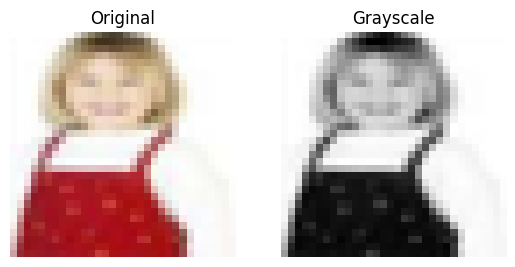

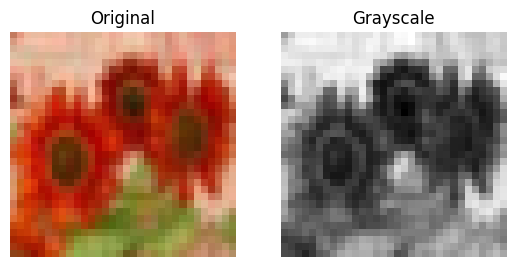

In [16]:
index = np.random.randint(2, len(y_train) - 1)
for original in y_train[index - 2:index]: compare(original)

### Prezentacja kolażu obrazów.

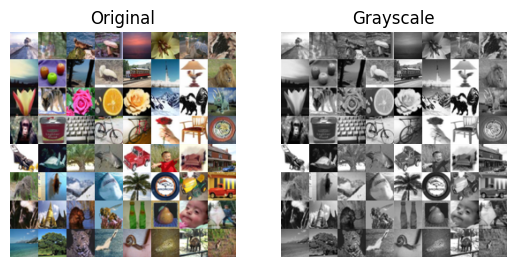

In [17]:
def square_collage(images, size: int = 8):
  (_, rows, cols, channels) = images.shape
  collage = images[:size * size]
  collage = collage.reshape((size, size, rows, cols, channels))
  return np.vstack([*map(np.hstack, collage)])

compare(square_collage(y_test), square_collage(x_test))

## Konstrukcja modelu sieci autoencoder.
- Konstrukcja sieci jst sparametryzowana o możliwość wprowadzenia:
  - use_normalization: bool -- batch normalization.
  - use_dropout: bool | float -- wykorzystanie dropout'u.
- Podczas trenowania sieci również są dostępne opcje:
  - use_weight_decay: float -- wykorzystanie weight decay podczas nauki.

### Model 'Encoder'.

In [18]:
class Encoder(Model):
  def __init__(self, layers_filters, use_normalization=False, use_dropout=False):
    super().__init__(name='encoder')
    def layers():
      for filters in layers_filters:
        yield Conv2D(filters, kernel_size=3, padding='same', activation='relu')
        if use_normalization:
          yield BatchNormalization()
        if use_dropout:
          yield Dropout(use_dropout)
    self.net = Sequential(list(layers()))

  def call(self, inputs):
    return self.net(inputs)

### Model 'Decoder'.

In [19]:
class Decoder(Model):
  def __init__(self, layers_filters):
    super().__init__(name='decoder')
    def layers():
      for filters in reversed(layers_filters):
        yield Conv2DTranspose(filters, kernel_size=3, padding='same', activation='relu')
      yield Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')

    self.net = Sequential(list(layers()))

  def call(self, inputs):
    return self.net(inputs)


### Podsumowanie enkodera i dekodera

In [20]:
layers_filters = [32, 64, 128, 256]
encoder = Decoder(layers_filters)
encoder.build(input_shape=(None, None, None, 1))
encoder.summary()
decoder = Encoder(layers_filters)
decoder.build(input_shape=(None, None, None, 3))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, None, None, 3)     390723    
                                                                 
Total params: 390,723
Trainable params: 390,723
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, None, None, 256)   388416    
                                                                 
Total params: 388,416
Trainable params: 388,416
Non-trainable params: 0
_________________________________________________________________


### Podsumowanie autoenkodera

In [21]:
class Autoencoder(Model):
  def __init__(self, layers_filters, use_normalization=False, use_dropout=False):
    super().__init__(name='autoencoder')
    def layers():
      yield Encoder(layers_filters, use_normalization, use_dropout)
      yield Decoder(layers_filters)
    self.net = Sequential(list(layers()))
  def call(self, inputs): return self.net(inputs)
autoencoder = Autoencoder(layers_filters)
autoencoder.build(input_shape=(None, None, None, 1))
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, None, None, 3)     1366083   
                                                                 
Total params: 1,366,083
Trainable params: 1,366,083
Non-trainable params: 0
_________________________________________________________________


### Training callbacks
- ReduceLROnPlateau - reduces lr by given value 0.1**0.5 every 3 epochs without improvement.
- ModalCheckpoint - saves model to given path every improved epoch.

### Training the network

In [ ]:
import tensorflow_addons as tfa

def train_model(model, weight_decay=0, savename=None):
  callbacks = [
    ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-6),
    ModelCheckpoint(filepath=f'models/{savename}.h5', monitor='val_loss', save_best_only=True)
  ]

  optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=weight_decay)

  model.compile(loss='mse', optimizer=optimizer)
  return model.fit(x_train, y_train, validation_data=(x_test, y_test),
                   epochs=20, batch_size=16, callbacks=callbacks)

histories = train_model(autoencoder)

Epoch 1/20
 145/3125 [>.............................] - ETA: 52s - loss: 0.0256

### Predict using autoencoder

In [ ]:
predicted = autoencoder.predict(x_test)

## Results side by side
### Multiple

In [ ]:
compare(square_collage(y_test), square_collage(predicted))

### Single Image

In [ ]:
for (original, prediction) in zip(y_test[:3], predicted[:3]): compare(original, prediction)

## Badania wpływu parametrów na wyjście i parametry walidujące.
Sieć kontrolna to:
Sieć bez dropout, bez normalizacji batch'y, bez weight decay oraz o rozmiarze filtrów warstw [64, 128, 256, 512]

In [ ]:
def plot_histories(*pairs, parameters):
  figure, axes = plt.subplots(ncols=len(parameters), figsize=(10, 3))
  (models, histories) = list(zip(*pairs))

  labels = [x.name for x in models]
  for axis, parameter in zip(axes.reshape(-1), parameters):
    for history in histories:
      axis.plot(history.history[parameter])
    axis.set_ylabel(parameter)
    axis.set_xlabel('epoch')
    axis.legend(labels, loc='upper right')
  plt.show()

# Przykładowy plot z parametrami learning_rate, val_loss oraz loss
plot_histories((autoencoder, histories), parameters=['lr', 'val_loss', 'loss'])

### Wpływ dropout rate.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- 0.05
  - Sieć III -- 0.15

In [ ]:
layers = [64, 128, 256, 512]
basemodel = Autoencoder(layers, use_dropout=0.00)
model_1 = Autoencoder(layers, use_dropout=0.05)
model_2 = Autoencoder(layers, use_dropout=0.15)

basemodel.build(input_shape=(None, None, None, 1))
model_1.build(input_shape=(None, None, None, 1))
model_2.build(input_shape=(None, None, None, 1))

pairs = [
  (basemodel, train_model(basemodel, savename='dropout-0.00.{epoch:03d}')),
  (model_1, train_model(model_1, savename='dropout-0.05.{epoch:03d}')),
  (model_2, train_model(model_2, savename='dropout-0.15.{epoch:03d}')),
]
plot_histories(*pairs, parameters=['val_loss', 'loss', 'lr'])


### Wpływ weight decay.
- Do badania został wykorzystany rozszerzenie AdamW optymalizator Adama.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- 0.10
  - Sieć III -- 0.25

In [ ]:
layers = [64, 128, 256, 512]
basemodel = Autoencoder(layers)
model_1 = Autoencoder(layers)
model_2 = Autoencoder(layers)

basemodel.build(input_shape=(None, None, None, 1))
model_1.build(input_shape=(None, None, None, 1))
model_2.build(input_shape=(None, None, None, 1))

histories = [
  (basemodel, train_model(basemodel, weight_decay=0.00, savename='decay-0.00.{epoch:03d}')),
  (model_1, train_model(model_1, weight_decay=0.10, savename='decay-0.10.{epoch:03d}')),
  (model_2, train_model(model_2, weight_decay=0.25, savename='decay-0.25.{epoch:03d}'))
]
plot_histories(*histories, parameters=['val_loss', 'loss', 'lr'])

### Wpływ rozmiaru batch normalization.
- Do badania została wykorzystana gotowa wartswa z tensorflow.keras BatchNormalization.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- istnieje

In [ ]:
layers = [64, 128, 256, 512]
basemodel = Autoencoder(layers, use_normalization=False)
model_1 = Autoencoder(layers, use_normalization=True)

basemodel.build(input_shape=(None, None, None, 1))
model_1.build(input_shape=(None, None, None, 1))

pairs = [
  (basemodel, train_model(basemodel, savename='batch-no.{epoch:03d}')),
  (model_1, train_model(model_1, savename='batch-yes.{epoch:03d}'))
]
plot_histories(*pairs, parameters=['val_loss', 'loss', 'lr'])

### Wpływ rozmiaru sieci.
- Do badania została wykorzystana gotowa wartswy z paczki tensorflow.keras.
- badane sieci:
  - Sieć I   -- Kontrolna | [64, 128, 256, 512]
  - Sieć II  -- [32, 64, 128]
  - Sieć III -- [32, 64, 128]

In [ ]:
basemodel = Autoencoder([64, 128, 256, 512])
model_1 = Autoencoder([32, 64, 128, 512, 512])
model_2 = Autoencoder([32, 64])

basemodel.build(input_shape=(None, None, None, 1))
model_1.build(input_shape=(None, None, None, 1))
model_2.build(input_shape=(None, None, None, 1))

pairs = [
  (basemodel, train_model(basemodel, savename='filters-medium.{epoch:03d}')),
  (model_1, train_model(model_1, savename='filters-bigger.{epoch:03d}')),
  (model_2, train_model(model_2, savename='filters-smaller.{epoch:03d}')),
]
plot_histories(*pairs, parameters=['val_loss', 'loss', 'lr'])

## Podsumowanie oraz Doświadczenia
- Tensorflow jest wstrętną technologią.
